# Mycoplasma Bovis analysis

Links

* https://www.ncbi.nlm.nih.gov/genome/browse/#!/prokaryotes/1150/

Bioprojects:

* Genomic epidemiology of Mycoplasma bovis in France: SRP386998
* Genome-Wide Identification of Variants Associated with Antimicrobial Resistance in Mycoplasma bovis: SRP349146
* Sanger Full_genome_sequencing_of_Mycoplasma_species_isolates_from_ruminants: PRJEB3408

Refs:

* [Genomics-based epidemiology of bovine Mycoplasma bovis strains in Israel](https://bmcgenomics.biomedcentral.com/articles/10.1186/s12864-020-6460-0#Sec13)
* [Population Genomic Analysis of Mycoplasma bovis Elucidates Geographical Variations and Genes associated with Host-Types](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7650767/)
* [Identification of Antimicrobial Resistance-Associated Genes through Whole Genome Sequencing of Mycoplasma bovis Isolates with Different Antimicrobial Resistances](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7400188/)

In [1]:
import os,sys,subprocess,glob
import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sns
from importlib import reload
from snipgenie import app, tools, wgmlst

In [4]:
df=pd.read_csv('results/samples.csv')

In [ ]:
df

## assembly

In [ ]:
for i,r in df[:-8].iterrows():    
    name = r['sample']
    print (name)
    if name in ['pure']: continue
    tools.spades(r.filename1,r.filename2, os.path.join('assembly',name), 'assembly/%s.fa' %name, 12)

## annotation

In [ ]:
out='annot'
files = glob.glob('assembly/*.fa')
a = [os.path.basename(i) for i in files]
print (files)

for f in files:
    n = os.path.splitext(os.path.basename(f))[0]
    cmd = 'prokka --outdir {o}/{n} {f} --prefix {n}'.format(f=f,n=n,o=out)#,p=path)
    print(cmd)
    #if not os.path.exists('%s/%s' %(out,n)):
        #print cmd
        #subprocess.check_output(cmd, shell=True)

## coverage

In [ ]:
reload(tools)
n=8
fig,ax=plt.subplots(n-1,1,figsize=(25,12))
axs=ax.flat
i=0
for idx,r in df.sample(n).iterrows(): 
    #print (r.bam_file)
    if pd.isnull(r.bam_file): continue   
    d=tools.samtools_depth(r.bam_file, start=180000,end=300000)
    x=groupby_interval(d,500,1000)
    ax=axs[i]
    x.plot(kind='area',ax=ax)
    label = r['sample']
    ax.text(.05,.8,label,color='blue',transform=ax.transAxes,fontsize=12)
    ax.set_xticklabels([])
    i+=1
sns.despine()
plt.tight_layout()

In [234]:
def groupby_interval(df, clip=2, interval=100):
    """Group over an interval - used for samtools depth data"""
    
    min = df.pos.min()
    max=df.pos.max()
    b = np.arange(min, max, interval)
    #rint (b)
    x=df.groupby(pd.cut(df.pos, bins=b, labels=b[:-1], right=False)).mean(numeric_only=True)['depth']
    x = x.clip(0,clip)
    x = x.replace(0,np.nan)
    return x.dropna()

In [ ]:
d=tools.samtools_depth('results/mapped/222A.bam')
data=groupby_interval(d,500,1000).dropna()
data

In [ ]:
from pycirclize import Circos
from pycirclize.parser import Genbank
from pycirclize.utils import load_prokaryote_example_file
import numpy as np
from matplotlib.patches import Patch

# Load Genbank file
gbk_file = 'NC_014760.gb'
gbk = Genbank(gbk_file)

circos = Circos(sectors={gbk.name: gbk.range_size}, start=0, end=320)
sector = circos.get_sector(gbk.name)
major_ticks_interval = 200000
minor_ticks_interval = 50000
outer_track = sector.add_track((98, 100))
outer_track.axis(fc="lightgrey")
outer_track.xticks_by_interval(
    major_ticks_interval, label_formatter=lambda v: f"{v/ 10 ** 6:.1f} Mb"
)
outer_track.xticks_by_interval(minor_ticks_interval, tick_length=1, show_label=False)

f_cds_track = sector.add_track((90, 97), r_pad_ratio=0.1)
f_cds_track.genomic_features(gbk.extract_features("CDS", target_strand=1), fc="red")
r_cds_track = sector.add_track((83, 90), r_pad_ratio=0.1)
r_cds_track.genomic_features(gbk.extract_features("CDS", target_strand=-1), fc="blue")

n=8
i=70
h=6
text_common_kws = dict(ha="right", va="center", size=8)
for idx,r in df.sample(n).iterrows(): 
    name = r['sample']
    if pd.isnull(r.bam_file): continue   
    d = tools.samtools_depth(r.bam_file)#, start=200000,end=350000)
    data = groupby_interval(d,500,2000)
    x=data.index
    y=data.values
    track = sector.add_track((i, i+h), r_pad_ratio=0.1)
    track.axis()
    #track.line(x, y)
    track.fill_between(x, y, ec="black", lw=.2)
    i-=h
    circos.text(name, r=i+h+2, color="black", **text_common_kws)

fig = circos.plotfig(160)

In [ ]:
from pycirclize import Circos
from io import StringIO
from Bio import Phylo
import numpy as np

np.random.seed(0)

tree = Phylo.read('results/tree.newick', "newick")
leaf_num = tree.count_terminals()

# Initialize circos sector with tree size
circos = Circos(sectors={"Tree": leaf_num}, start=-350, end=0)
sector = circos.sectors[0]

# Plot tree
tree_track = sector.add_track((30, 80))
tree_track.tree(
    tree,
    use_branch_length=True, 
    leaf_label_size=10,
    leaf_label_margin=2, # Set large margin for heatmap plot
    
)

# Plot heatmap
heatmap_track = sector.add_track((100, 120))
matrix_data = np.random.randint(0, 100, (5, leaf_num))
heatmap_track.heatmap(matrix_data, cmap="viridis")
heatmap_track.yticks([0.5, 1.5, 2.5, 3.5, 4.5], list("ABCDE"), vmax=5, tick_length=0)

fig = circos.plotfig()


## AMR SNPs

In [35]:
C=pd.read_csv('results/csq.matrix')
C.snp_type.value_counts()

synonymous                  9188
missense                    6645
*synonymous                  631
*missense                    506
stop_gained                   89
stop_lost                     84
*stop_lost                    17
*stop_gained                  14
synonymous&stop_retained       6
start_lost                     4
Name: snp_type, dtype: int64

In [37]:
S=C[C.snp_type=='stop_lost']
S

,start,gene,aa,snp_type,221,222A,223,224,224B,224B21,...,GB000944,GB17005644,GB18000923,GB18001319,PURE,SRR17119177,SRR20305624,SRR20305655,SRR20305659,pure
271,36547,MBOVPG45_RS00180,54*>54R,stop_lost,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
345,41186,MBOVPG45_RS00190,2825*>2825W,stop_lost,1,1,1,0,1,1,...,1,1,1,0,0,0,1,1,1,0
404,41906,MBOVPG45_RS00190,2585*>2585W,stop_lost,1,1,1,1,1,1,...,1,1,1,0,0,0,1,1,1,0
755,50932,MBOVPG45_RS00195,178*>178Y,stop_lost,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1048,67188,rsmA,218*>218W,stop_lost,1,1,1,1,1,1,...,1,1,1,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16075,941185,MBOVPG45_RS04055,287*>287E,stop_lost,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,0
16076,941185,MBOVPG45_RS04055,stop_lost,stop_lost,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,0
16218,952691,MBOVPG45_RS04115,384*>384Y,stop_lost,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
16219,952691,MBOVPG45_RS04115,stop_lost,stop_lost,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
M=C[C.snp_type=='missense']
freq = M.iloc[:,4:].sum(axis=1)
M=M[freq>4]
M=C[C.snp_type=='stop_lost']

,start,gene,aa,snp_type,221,222A,223,224,224B,224B21,...,GB000944,GB17005644,GB18000923,GB18001319,PURE,SRR17119177,SRR20305624,SRR20305655,SRR20305659,pure
43,1717,MBOVPG45_RS00010,59V>59I,missense,1,1,1,1,1,1,...,1,1,1,1,0,0,1,1,1,0
46,1915,MBOVPG45_RS00010,125I>125L,missense,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
132,4439,MBOVPG45_RS00035,157S>157T,missense,1,1,1,1,1,1,...,1,1,1,1,0,0,1,1,1,0
147,5197,MBOVPG45_RS00040,267S>267G,missense,1,1,1,1,1,1,...,1,1,1,1,0,1,1,1,1,0
160,5880,MBOVPG45_RS00040,39T>39S,missense,1,1,1,1,1,1,...,1,1,1,1,0,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17076,996789,MBOVPG45_RS04315,160S>160P,missense,1,1,1,1,1,1,...,1,1,1,1,0,0,1,1,1,0
17077,996846,MBOVPG45_RS04315,141L>141I,missense,1,1,1,1,1,1,...,1,1,1,1,0,1,1,1,1,0
17078,996852,MBOVPG45_RS04315,139Y>139H,missense,1,1,1,1,1,1,...,1,1,1,1,0,0,1,1,1,0
17080,996876,MBOVPG45_RS04315,131E>131K,missense,1,1,1,1,1,1,...,1,1,1,1,0,0,1,1,0,0


/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


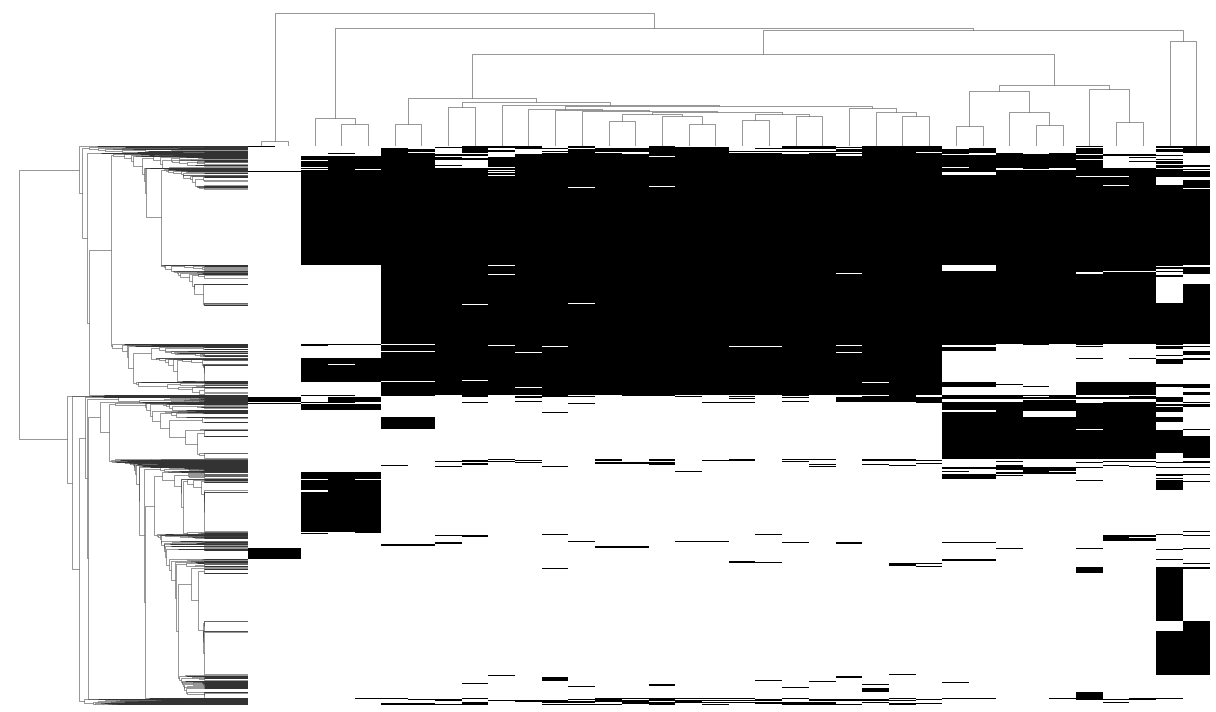

In [34]:
X=C.iloc[:,4:]
#colors,colormap=plotting.get_color_mapping(C,county1',cmap='Set1')
cg = sns.clustermap(X,xticklabels=False,yticklabels=False,cmap='gray_r',cbar_pos=None,figsize=(17,10)) #row_colors=[colors1,colors2]


## kraken